# imports

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from scipy.stats import norm, rayleigh, gamma
from tools import get_mids
from os.path import join
from settings import ngc1068, BASEPATH

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
matplotlib = sns.mpl
plt = matplotlib.pyplot

BASEPATH = "/home/lisajsch/notebooks/Plenum/"

In [2]:
fisher = pd.read_pickle(join(BASEPATH, "resources/fisher_casc.pickle"))
# give a name to the first index
fisher.index.names = ['config', 'spacing', 'energy', 'pmts']

# loading effective areas


In [3]:
cosT_bins_raw, logE_bins_raw, aeffs = pd.read_pickle(
    join(BASEPATH, "resources/aeff_cluster_nuecc_with-eq.pickle")
)
cosT_bins = np.linspace(-1, 1, num=101)
logE_bins = np.linspace(3, 6, num=91)

In [4]:
# check if any values are negative, just in case...
for i, aeff in aeffs.iterrows():
    v = np.count_nonzero(aeff["aeff_hist"].flatten() < 0)
    if v>0:
        print(aeff["aeff_hist"][aeff["aeff_hist"]<0])
        break

## binning

In [5]:
aeff = aeffs.iloc[0]["aeff_hist"]
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

logE_reco_bins = np.linspace(logE_bins[0], logE_bins[-1], num=len(logE_bins)+3)
logE_reco_mids = get_mids(logE_reco_bins)

cosT_mids = get_mids(cosT_bins)
cosT_width = np.diff(cosT_bins)

ra_bins = np.linspace(0, np.pi * 2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

print(len(emids), "log_10(energy) bins")
print(len(logE_reco_mids), "log_10(reco energy) bins")
print(len(cosT_mids), "declination bins")

90 log_10(energy) bins
93 log_10(reco energy) bins
100 declination bins


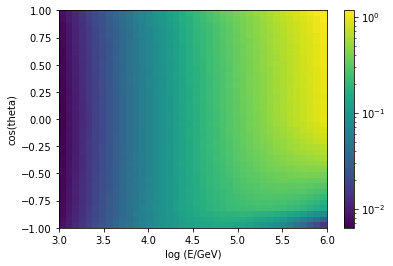

In [6]:
plt.pcolormesh(logE_bins_raw, cosT_bins_raw, aeff, norm=LogNorm()) #vmin=1E-5, vmax=1
plt.xlabel("log (E/GeV)")
plt.ylabel("cos(theta)")
plt.colorbar()

# rotate to global coordinates

In [7]:
from aeff_calculations import setup_aeff_grid, aeff_rotation
from settings import poles
from scipy.interpolate import RegularGridInterpolator

In [8]:
aeff_eq = []
k = "P-ONE"
for aeff in aeffs["aeff_hist"]:
    # improve resolution
    aeff_pad = np.pad(aeff, 1, mode="edge")
    pad_E = np.pad(get_mids(logE_bins_raw), 1, mode="edge")
    pad_E[0] -= pad_E[2]-pad_E[1]
    pad_E[-1] += (pad_E[-2]-pad_E[-3])

    pad_C = np.pad(get_mids(cosT_bins_raw), 1, mode="edge")
    pad_C[0] -= pad_C[2]-pad_C[1]
    pad_C[-1] += (pad_C[-2]-pad_C[-3])
    a_rgi = RegularGridInterpolator((pad_C, pad_E), aeff_pad)

    ee, cc = np.meshgrid(logE_mids, cosT_mids)
    aeff_new = a_rgi((cc, ee))

    # setup evaluation grids
    grid2d, eq_coords = setup_aeff_grid(
        aeff_new.T, cosT_mids, ra_mids, ra_width
    )

    aeff_eq.append(aeff_rotation(
        poles[k]["lat"], poles[k]["lon"], eq_coords, grid2d, ra_width
    ) *1E4 ) # m^2 -> cm^2

aeffs["equatorial_fine"] = aeff_eq

In [9]:
pd.to_pickle(
    (cosT_bins, logE_bins, aeffs),
    join(BASEPATH, "resources/aeff_cluster_nuecc_with-eq.pickle"),
)


# plotting comp

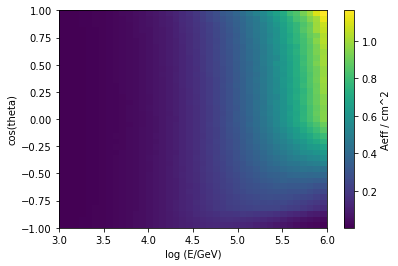

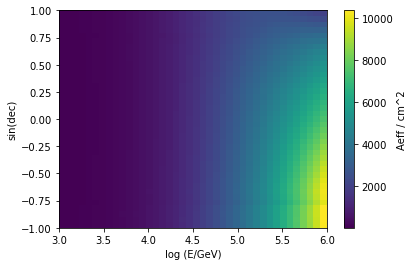

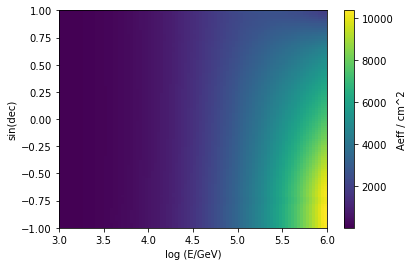

In [10]:
plt.figure()
plt.pcolormesh(
    logE_bins_raw, cosT_bins_raw, aeffs.iloc[7]["aeff_hist"], #norm=LogNorm(vmin=1e-5, vmax=1)
)
plt.xlabel("log (E/GeV)")
plt.ylabel("cos(theta)")
cb = plt.colorbar()
cb.set_label("Aeff / cm^2")


plt.figure()
plt.pcolormesh(
    logE_bins_raw, cosT_bins_raw, aeffs.iloc[7]["equatorial"].T, #norm=LogNorm(vmin=1e-5, vmax=1)
)
plt.xlabel("log (E/GeV)")
plt.ylabel("sin(dec)")
cb = plt.colorbar()
cb.set_label("Aeff / cm^2")

plt.figure()
plt.pcolormesh(
    logE_bins, cosT_bins, aeffs.iloc[7]["equatorial_fine"].T, #norm=LogNorm(vmin=1e-5, vmax=1)
)
plt.xlabel("log (E/GeV)")
plt.ylabel("sin(dec)")
cb = plt.colorbar()
cb.set_label("Aeff / cm^2")


# load fisher information data

In [11]:
fisher = pd.read_pickle(join(BASEPATH, "resources/fisher_casc.pickle"))
# give a name to the first index
fisher.index.names = ['config', 'spacing', 'energy', 'pmts']

## testing with plots

('Full optimistic triang', 50.0, 16)
config: Full optimistic triang, spacing: 50.0, pmts: 16, 


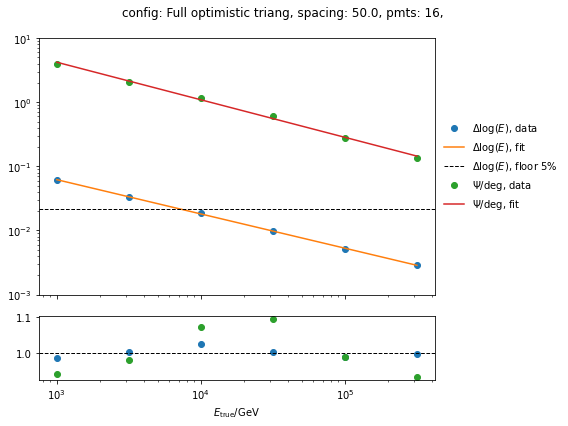

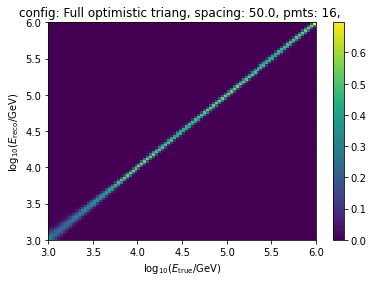

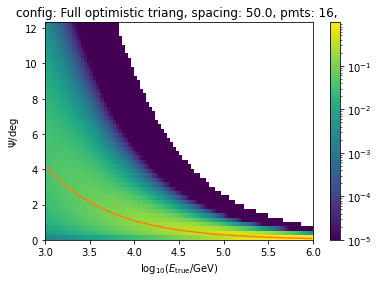

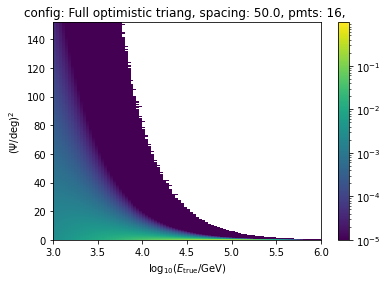

In [12]:
for ident, series in fisher.groupby(["config", "spacing", "pmts"]):
    print(ident)
    ident_str = ""
    for val, name in zip(ident, ["config", "spacing", "pmts"]):
        ident_str += ": ".join([name, str(val)]) + ", "
    print(ident_str)
    true_E = series.index.get_level_values(2).values
    width_E = series.logE.values
    width_psi = series.ang_res_sampl.values
    width_E_floor = 0.05 / np.log(10)

    # interpolate
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle(ident_str)

    gs = GridSpec(2, 1, height_ratios=[4, 1])
    ax1 = fig.add_subplot(gs[0])

    # energy width
    fit_we = np.poly1d(np.polyfit(np.log10(true_E), np.log10(width_E), 1))
    p1 = ax1.plot(true_E, width_E, marker="o", lw=0, label=r"$\Delta \log(E)$, data")
    ax1.plot(true_E, 10 ** fit_we(np.log10(true_E)), label=r"$\Delta \log(E)$, fit")
    ax1.axhline(
        width_E_floor, label=r"$\Delta \log(E)$, floor 5%", color="k", ls="--", lw=1
    )

    # psi
    fit_wps = np.poly1d(np.polyfit(np.log10(true_E), np.log10(width_psi), 1))
    p2 = ax1.plot(
        true_E, width_psi, marker="o", lw=0, label=r"$\Psi / {\rm deg}$, data"
    )
    ax1.plot(true_E, 10 ** fit_wps(np.log10(true_E)), label=r"$\Psi / {\rm deg}$, fit")

    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.tick_params(axis="x", labelbottom=False)
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5), framealpha=0)
    ax1.set_ylim(1e-3, 10)

    ax2 = fig.add_subplot(gs[1])

    ax2.plot(
        true_E,
        width_E / 10 ** fit_we(np.log10(true_E)),
        marker="o",
        lw=0,
        label=r"$\Delta \log(E)$, data/fit",
        color=p1[0].get_color(),
    )
    ax2.plot(
        true_E,
        width_psi / 10 ** fit_wps(np.log10(true_E)),
        marker="o",
        lw=0,
        label=r"$\Psi / {\rm deg}$, data/fit",
        color=p2[0].get_color(),
    )
    ax2.axhline(1, color="k", ls="--", lw=1)
    ax2.set_xscale("log")
    ax2.set_xlabel(r"$E_{\rm true} / {\rm GeV}$")
    fig.tight_layout()

    # energy resolution
    eres_all = []
    for et in logE_mids:
        if 10 ** fit_we(et) <= width_E_floor:
            tmp = width_E_floor
        else:
            tmp = 10 ** fit_we(et)
        # integrate over bin
        eres = norm.cdf(logE_reco_bins[1:], loc=et, scale=tmp) - norm.cdf(
            logE_reco_bins[:-1], loc=et, scale=tmp
        )
        eres_all.append(eres / np.sum(eres))  # normalize
    eres_all = np.array(eres_all).T
    plt.figure()
    plt.pcolormesh(logE_bins, logE_reco_bins, eres_all)  # , norm=LogNorm(vmin=1e-5))
    plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
    plt.ylabel(r"$\log_{10}(E_{\rm reco} / {\rm GeV})$")
    plt.title(ident_str)
    plt.colorbar()

    # angular resolution
    ## based on psi
    psi_max = 3* 10 ** fit_wps(logE_mids[0])
    if psi_max > 90:
        psi_max = 90
    
    psi_bins = np.linspace(0, psi_max, num=50)
    psi_mids = get_mids(psi_bins)
    psi_all = []
    for et in logE_mids:
        # integrate over bin
        tmp = rayleigh.cdf(psi_bins[1:], loc=0, scale=10 ** fit_wps(et)) - rayleigh.cdf(
            psi_bins[:-1], loc=0, scale=10 ** fit_wps(et)
        )
        psi_all.append(tmp / np.sum(tmp))
    psi_all = np.array(psi_all).T

    plt.figure()
    plt.pcolormesh(logE_bins, psi_bins, psi_all, norm=LogNorm(vmin=1e-5))
    plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
    plt.ylabel(r"$\Psi / {\rm deg} $")
    plt.title(ident_str)
    plt.plot(logE_mids, 10 ** fit_wps(logE_mids), color="tab:orange")
    plt.colorbar()

    ## based on psi²
    psi2_bins = np.arange(0, psi_max**2, step=0.1)
    psi2_mids = get_mids(psi2_bins)
    psi2_all = []
    for et in logE_mids:
        # integrate over bin
        tmp = gamma.cdf(
            psi2_bins[1:], 1, scale=2 * (10 ** fit_wps(et)) ** 2
        ) - gamma.cdf(psi2_bins[:-1], 1, scale=2 * (10 ** fit_wps(et)) ** 2)
        psi2_all.append(tmp / np.sum(tmp))
    psi2_all = np.array(psi2_all).T

    plt.figure()
    plt.pcolormesh(logE_bins, psi2_bins, psi2_all, norm=LogNorm(vmin=1e-5))
    plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
    plt.ylabel(r"$(\Psi / {\rm deg})^2$")
    plt.title(ident_str)
    plt.colorbar()
    break
    plt.show()


## looping over all settings (without plots)

In [13]:
pdlist_energy = []
pdlist_psi = []
for ident, series in fisher.groupby(["config", "spacing", "pmts"]):
    dct = {"config": ident[0], "spacing": ident[1], "pmts": ident[2]}

    true_E = series.index.get_level_values(2).values
    width_E = series.logE.values
    width_psi = series.ang_res_sampl.values
    width_E_floor = 0.05 / np.log(10)

    # interpolate
    ## energy width
    mask = np.isfinite(width_E)
    fit_we = np.poly1d(np.polyfit(np.log10(true_E[mask]), np.log10(width_E[mask]), 1))
    ## psi
    fit_wps = np.poly1d(np.polyfit(np.log10(true_E), np.log10(width_psi), 1))

    # energy resolution
    eres_all = []
    for et in logE_mids:
        if 10 ** fit_we(et) <= width_E_floor:
            tmp = width_E_floor
        else:
            tmp = 10 ** fit_we(et)
        # integrate over bin
        eres = norm.cdf(logE_reco_bins[1:], loc=et, scale=tmp) - norm.cdf(
            logE_reco_bins[:-1], loc=et, scale=tmp
        )
        eres_all.append(eres / np.sum(eres))
    eres_all = np.array(eres_all).T
    dct["energy_res"] = eres_all
    # dct["energy_rgi"] = RegularGridInterpolator((logE_reco_mids, logE_mids), eres_all)
    dct["etrue_bins"] = logE_bins
    dct["ereco_bins"] = logE_reco_bins
    pdlist_energy.append(dct)

    dct = {"config": ident[0], "spacing": ident[1], "pmts": ident[2]}
    ## based on psi²
    psi_max = 5 * 10 ** fit_wps(logE_mids[0])
    if psi_max > 90:
        psi_max = 90
    reso_psi2_bins = np.arange(0, psi_max**2, step=0.1)
    reso_psi2_mids = get_mids(reso_psi2_bins)
    psi2_all = []
    for et in logE_mids:
        # integrate over bin
        tmp = gamma.cdf(
            reso_psi2_bins[1:], 1, scale=2 * (10 ** fit_wps(et)) ** 2
        ) - gamma.cdf(reso_psi2_bins[:-1], 1, scale=2 * (10 ** fit_wps(et)) ** 2)
        psi2_all.append(tmp / np.sum(tmp))
    psi2_all = np.array(psi2_all).T
    dct["etrue_bins"] = logE_bins
    dct["psi2"] = psi2_all
    dct["psi2_bins"] = reso_psi2_bins

    pdlist_psi.append(dct)
pd_save_energy = pd.DataFrame(pdlist_energy)
pd_save_psi = pd.DataFrame(pdlist_psi)


In [14]:
pd.to_pickle(pd_save_energy, join(BASEPATH, "resources/optimization_resolutions_energy.pickle"))
pd.to_pickle(pd_save_psi, join(BASEPATH, "resources/optimization_resolutions_psi.pickle"))

In [15]:
raise BaseException(" ;> ")

BaseException:  ;> 

# testing: psi -> psi² == Rayleigh(s) -> Gamma(1, 2 * s²)

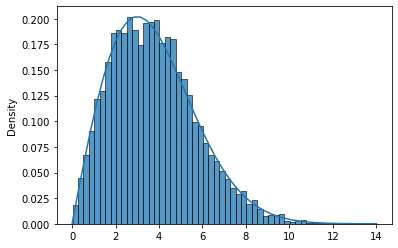

In [ ]:
sigma = 3
nsamp = int(1E4)

xs = np.linspace(0, 14)
x = rayleigh.rvs(scale=sigma, size=nsamp)
ax = sns.histplot(x, stat="density")
ax.plot(xs, rayleigh.pdf(xs, scale=sigma))

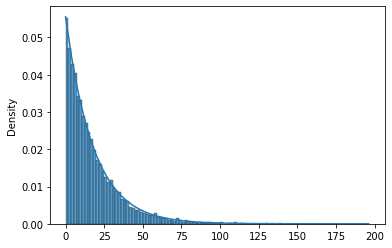

In [ ]:
xs = np.linspace(0, 14**2)
x = rayleigh.rvs(scale=sigma, size=nsamp) ** 2
ax = sns.histplot(x, stat="density")
ax.plot(xs, gamma.pdf(xs, 1, scale= 2 * sigma ** 2))